In [ ]:
#libraries installation
!pip install roboflow
!pip install ultralytics
!pip install wandb

In [ ]:
from roboflow import Roboflow
import os
from kaggle_secrets import UserSecretsClient

# use this code for load dataset from roboflow
user_secrets = UserSecretsClient()
secret_value_1 = user_secrets.get_secret("Roboflow_api")
rf = Roboflow(api_key=secret_value_1)
project = rf.workspace("dronecv").project("mineguard-color")
version = project.version(4)
dataset = version.download("yolov8")


In [ ]:
from ultralytics import YOLO
import ray
from ray import tune
import wandb


secret_value_0 = user_secrets.get_secret("wandb_key") # specify api key for wandb login

os.environ["WANDB_API_KEY"] = secret_value_0

wandb.login()

ray.shutdown()
ray.init(num_gpus=1)  # specify that 1 GPU should be used

In [ ]:
model = YOLO('yolov8s.pt') #load pre-trained model, yolov8s was chosen according to capacity Nvidia Jetson Nano

In [ ]:
#find best parameters for our model
result_grid = model.tune(
    data= "/kaggle/working/MineGuard-Color-4/data.yaml",
    space={
        "lr0": tune.uniform(1e-5, 1e-1),
        "momentum": tune.uniform(0.6, 0.98),
        "weight_decay": tune.uniform(0.0, 0.001),
    },
    epochs=10,
    use_ray=True,
    iterations=5,
    gpu_per_trial=1,

)

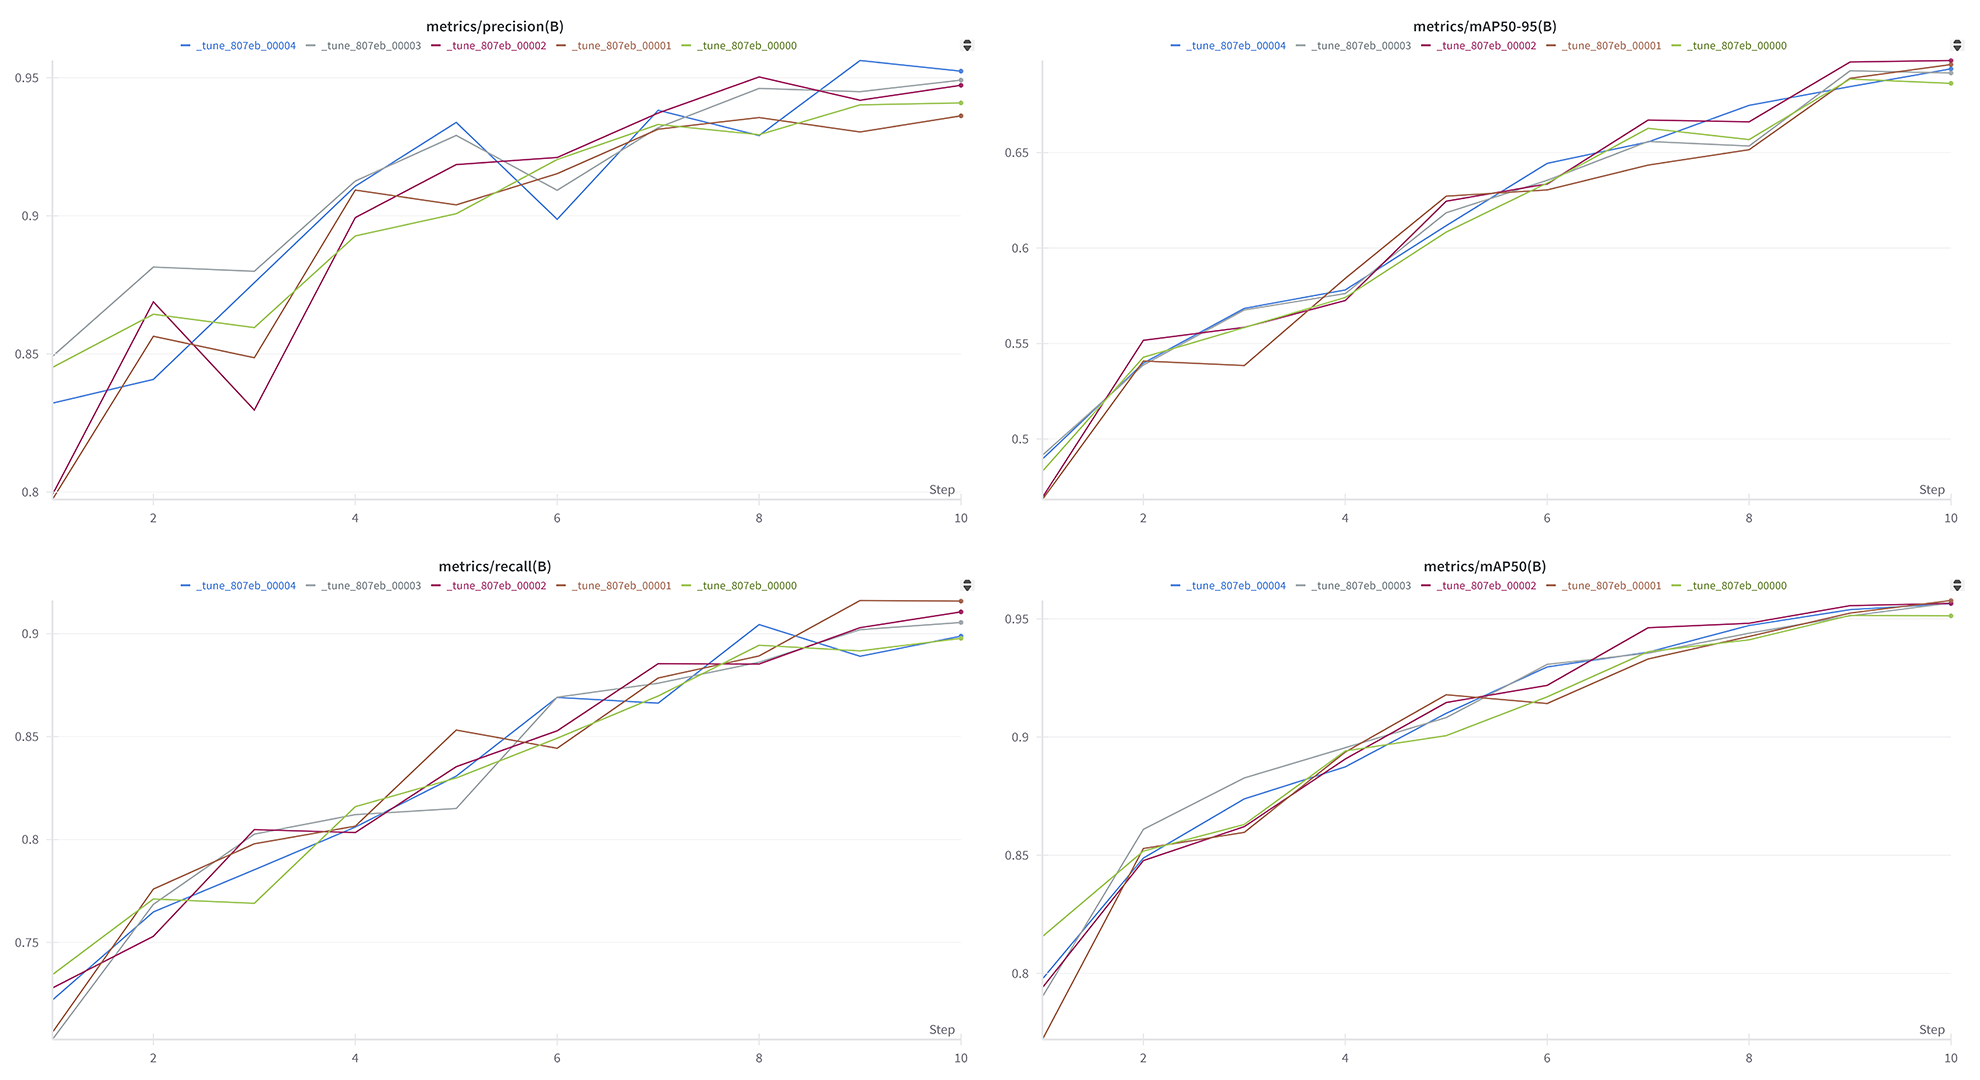

In [ ]:
!zip -r runs.zip /kaggle/working/runs

In [ ]:
#load best config from wandb
api = wandb.Api()
run_path = "gr0nt0nbith-khpi/YOLOv8-tune/807eb_00001"
run = api.run(run_path)
config = run.config


In [ ]:
#determinate hyperparameters and train model
hyperparameters = {
    "data": "/kaggle/working/MineGuard-Color-4/data.yaml",
    "epochs": 30,
    "lr0": config["lr0"],
    "momentum": config["momentum"],
    "weight_decay": config["weight_decay"],
    "batch": 16,
    "imgsz": 640,
}
model.train(**hyperparameters)

In [ ]:
# evaluate the accuracy of the model on a test data set
results = model.val(data="/kaggle/working/MineGuard-Color-4/data.yaml")

$$
\begin{array}{lcccccc}
\hline
Class & Images & Instances & P & R & mAP@0.5 & mAP@0.5:0.95 \\
\hline
all   & 1059 & 1771 & 0.952 & 0.939 & 0.970 & 0.733 \\
MON-50 & 134 & 215 & 0.931 & 0.972 & 0.983 & 0.775 \\
OZM-72 & 127 & 194 & 0.958 & 0.929 & 0.975 & 0.697 \\
PFM-1 & 108 & 166 & 0.935 & 0.892 & 0.942 & 0.678 \\
PMN   & 130 & 224 & 0.981 & 0.947 & 0.986 & 0.707 \\
PMN-2 & 141 & 302 & 0.969 & 0.983 & 0.990 & 0.834 \\
POM-2 & 177 & 331 & 0.947 & 0.894 & 0.954 & 0.743 \\
POMZ  & 98  & 144 & 0.932 & 0.958 & 0.961 & 0.678 \\
TM    & 126 & 195 & 0.961 & 0.933 & 0.968 & 0.752 \\
\hline
\end{array}
$$

The trained model performs quite well, especially considering it was trained on synthetic data. Precision starting from 93.1% indicates a low number of false positives. Recall ranging from 89.2% (up to 90% for mines painted in ground-like colors) suggests a small percentage of misses. Mean Average Precision (mAP@0.5) is high, starting from 0.942 across all classes, confirming good detection quality. mAP@0.5:0.95, as a stricter metric, shows lower results (from 0.678), but this is not critical for the project's objectives

**Test the model on real data.**

In [ ]:
#download test video and model from google drive
!gdown "14lPmER5VRY2QGzkL6zV1-LugytUXLgPI"
!gdown '1peG2N_dgeVLWtgEgJX76-tgzPTqVPqGA'

Downloading...
From: https://drive.google.com/uc?id=14lPmER5VRY2QGzkL6zV1-LugytUXLgPI
To: /kaggle/working/VID_20240623_212829.mp4
100%|██████████████████████████████████████| 46.0M/46.0M [00:05<00:00, 8.64MB/s]
Downloading...
From: https://drive.google.com/uc?id=1peG2N_dgeVLWtgEgJX76-tgzPTqVPqGA
To: /kaggle/working/best_rgb.pt
100%|██████████████████████████████████████| 22.5M/22.5M [00:02<00:00, 9.09MB/s]


In [ ]:
import cv2
import numpy as np


# load the YOLO model
model = YOLO('/kaggle/working/best_rgb.pt')

# path to the input video
video_path = '/kaggle/working/VID_20240623_212829.mp4'
cap = cv2.VideoCapture(video_path)

# check if the video file opened successfully
if not cap.isOpened():
    print("Error: Could not open video file")
    exit()

# set up the output video writer
output_path = '/kaggle/working/output_video_with_conf_filter.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
class_names = model.names # extract names of classses for drawing bounding boxes

ret = True
while ret:
    ret, frame = cap.read()
    if ret:
        # detect and track objects in the frame
        results = model.track(frame, persist=True)

        # extract detection data
        boxes = results[0].boxes.xyxy.cpu().numpy()  # bounding box
        confs = results[0].boxes.conf.cpu().numpy()  # confidence scores
        ids = results[0].boxes.id.cpu().numpy() if results[0].boxes.id is not None else None  # tracking ID

        # draw bounding boxes
        for i, box in enumerate(boxes):
            conf = confs[i]
            if conf >= 0.4:  # draw boxes if confidence > 40%
                x1, y1, x2, y2 = map(int, box)
                obj_id = int(ids[i]) if ids is not None else -1

                class_id = int(classes[i])
                class_name = class_names[class_id]

                # draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                # add label with ID, confidence and classes
                label = f'ID: {obj_id} Conf: {conf:.2f} {class_name}'
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # Write the processed frame to the output video
        out.write(frame)

# Release resources when done
cap.release()
out.release()


In the next photo, we can see the results of the model working in real life

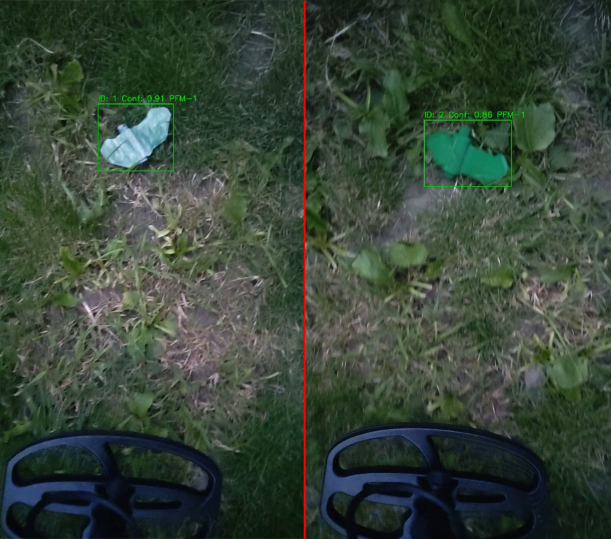